Emilien L'Haridon - Ulysse Devincre
Machine utilisée : Google Colab et machine salle D117

# TP2 Réseau de Neurone - CNN

In [ ]:
import time
import copy
import torch
import torchvision
import torchvision.transforms as transforms

import os
os.environ['HTTP_PROXY'] = 'http://cache.ha.univ-nantes.fr:3128'
os.environ['HTTPS_PROXY'] = 'http://cache.ha.univ-nantes.fr:3128'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)


cuda:0


## Preparation of the dataset
The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].

In [ ]:
transform = transforms.Compose(
    [transforms.Pad(2),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# size of the mini batch
minibatchsize = 32

datadir = './data'
fulltrainset = torchvision.datasets.MNIST(root=datadir, train=True,
                                        download=True, transform=transform)

#split the full train part as train and validation (10K samples, some can be ignored):
trainset, validationset, _ignored_part = torch.utils.data.random_split(fulltrainset, [30000,10000, 20000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatchsize,
                                          shuffle=True, num_workers=0)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=minibatchsize,
                                          shuffle=False, num_workers=0)

testset = torchvision.datasets.MNIST(root=datadir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatchsize,
                                         shuffle=False, num_workers=0)

# define the set of class names :
classes = range(0,10)
nb_classes = len(classes)

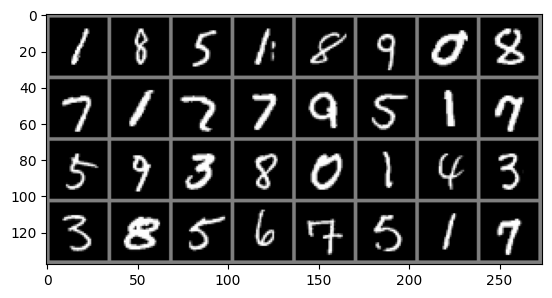

    1     8     5     1


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img, filename=''):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if filename == '':
        plt.show()
    else:
        plt.savefig(name)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Define a CNN

Propose a CNN constructor that takes meta-parameters as arguments (nb conv layers, nb kernel per conv, nb FC layers, nb hidden cells per fc)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# this class define the CNN architecture
# default architecture is close to LeNet5 one
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x


In [ ]:
########################################################################
# Define the network to use :
net = NetCNN()
net.to(device) # move it to GPU or CPU
# show the structure :
print(net)

NetCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Define a Loss function and optimizer

In [ ]:
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Q1: Optimize the architecture

1. Reuse the training function from the previous TP
2. Analyse your network : recognition rate, confusion matrix
3. Select one meta-paramter (or 2 depending on the available time) and draw the curve showing the loss depending  on this parameter
4. Evaluate and analyse the best network, compute the number of free parameters (complexity). See documentation of [nn.Module.parameters()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters).

1. Training function

In [ ]:
from sklearn.metrics import confusion_matrix


def train_network(net, trainloader,validationloader, validationset, criterion, optimizer, num_epochs=5, print_every=200):
    # Definition of arrays to store the results and draw the learning curves
    val_err_array = np.array([])
    train_err_array = np.array([])
    nb_sample_array = np.array([])

    # best system results
    best_val_loss = 1000000
    best_nb_sample = 0
    best_model =  copy.deepcopy(net)

    nb_used_sample = 0
    running_loss = 0.0

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        start_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # count how many samples have been used during the training
            nb_used_sample += minibatchsize
            # print/save statistics
            running_loss += loss.item()
            if nb_used_sample % (print_every * minibatchsize) == 0:    # print every ""print_every"" mini-batches
                train_err = (running_loss / (print_every * minibatchsize))
                print('Epoch %d batch %5d ' % (epoch + 1, i + 1))
                print('Train loss : %.3f' % train_err)
                running_loss = 0.0
                #evaluation on validation set
                totalValLoss = 0.0
                with torch.no_grad():
                    for data in validationloader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criterion(outputs, labels)
                        totalValLoss += loss.item()
                val_err = (totalValLoss / len(validationset))
                print('Validation loss mean : %.3f' % val_err)
                train_err_array = np.append(train_err_array, train_err)
                val_err_array = np.append(val_err_array, val_err)
                nb_sample_array = np.append(nb_sample_array, nb_used_sample)

                # save the model and update best_val_loss and best_nb_sample only when loss is better
                if val_err < best_val_loss:
                    best_val_loss = val_err
                    best_nb_sample = nb_used_sample
                    best_model =  copy.deepcopy(net)
                    print('New best model saved at %d samples' % best_nb_sample)

        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))

    print('Finished Training')

    # learning curves
    plt.clf()
    plt.xlabel('epoch')
    plt.ylabel('val / train LOSS')
    plt.title('Digit classifier')
    plt.plot(nb_sample_array.tolist(), val_err_array.tolist(), 'b',nb_sample_array.tolist(), train_err_array.tolist(), 'r', [best_nb_sample], [best_val_loss],         'go')
    plt.legend(['Validation loss', 'Train loss', 'Best model'])
    plt.show()
    return best_model, train_err_array, val_err_array

def evaluate(model, dataloader, device):
    model = model.to(device)
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = 100 * correct / total
    print('Accuracy: ', accuracy, '%')
    print('Error rate: ', 100 - accuracy, '%')
    print('Confusion Matrix: \n ', confusion_matrix(all_labels, all_preds))
    # complexity
    complexity = sum(p.numel() for p in model.parameters())
    print('Complexity : ', complexity)
    return accuracy, complexity

test_net = NetCNN()
test_net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(test_net.parameters(), lr=0.01, momentum=0.9)

best_model, train_err, val_errs = train_network(test_net, trainloader, validationloader, validationset, criterion, optimizer, num_epochs = 5, print_every = 200)


2. Analysis of the network

In [ ]:
evaluate(best_model, testloader, criterion, device)

Accuracy:  92.82
Average Loss:  1.538195236041523
Confusion Matrix: 
  [[ 945    0    5    0    1    0   12    2   15    0]
 [   0 1076    2    4    7    0    4    0   42    0]
 [   9    0  920   22   15    0    7   10   48    1]
 [   0    0    6  958    1    8    0    3   30    4]
 [   0    0    3    0  966    0    4    1    5    3]
 [   6    2    3   28   18  698   20    4  100   13]
 [   5    1    3    0   19    1  921    0    8    0]
 [   1    8   27    8   11    0    0  937    7   29]
 [   5    0    1    3    9    0    1    2  939   14]
 [   8    2    1    6   38    3    0   11   18  922]]


1.538195236041523

```
Confusion Matrix:
  [[ 947    0    9    0    0    5   11    2    5    1]
 [   0 1122    8    0    1    0    4    0    0    0]
 [   1    1 1016    0    2    0    2    8    2    0]
 [   1    2  317    0    0  261    0   47  337   45]
 [   1    1    1    0  953    0    5    2    1   18]
 [   1    0    1    0    0  870    5    1    8    6]
 [   3    3    0    0    4    5  938    0    5    0]
 [   1    1   15    0    2    0    0 1005    1    3]
 [   4    7   13    0    4    6    3   11  916   10]
 [   3    5    1    0    9    6    1   14   13  957]]
```

Accuracy / Recognition Rate : 92.82


3. Optimization of two meta-parameters

We choose to optimize the momentum and the learning rate, because they were easy to iterate and to optimize.


Testing lr:  0.1  and momentum:  0.8
Epoch 1 batch   200 
Train loss : 0.069
Validation loss mean : 0.058
New best model saved at 6400 samples
Epoch 1 of 5 took 8.153s
Epoch 2 batch    87 
Train loss : 0.058
Validation loss mean : 0.056
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.056
Validation loss mean : 0.056
New best model saved at 19200 samples
Epoch 2 of 5 took 9.046s
Epoch 3 batch   174 
Train loss : 0.056
Validation loss mean : 0.055
New best model saved at 25600 samples
Epoch 3 of 5 took 5.816s
Epoch 4 batch    61 
Train loss : 0.054
Validation loss mean : 0.051
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.051
Validation loss mean : 0.050
New best model saved at 38400 samples
Epoch 4 of 5 took 9.411s
Epoch 5 batch   148 
Train loss : 0.050
Validation loss mean : 0.050
Epoch 5 of 5 took 6.642s
Finished Training


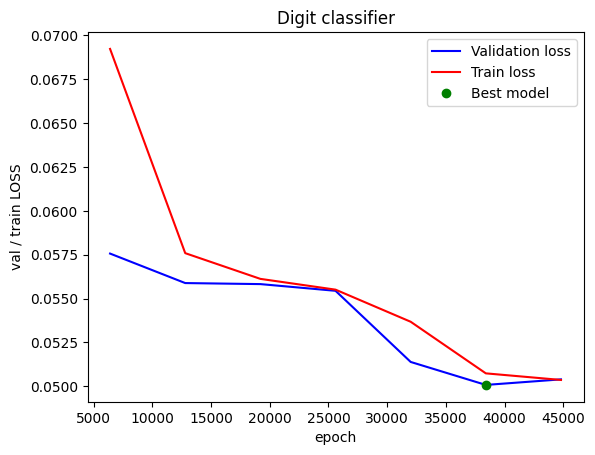

Testing lr:  0.1  and momentum:  0.85
Epoch 1 batch   200 
Train loss : 0.065
Validation loss mean : 0.052
New best model saved at 6400 samples
Epoch 1 of 5 took 5.848s
Epoch 2 batch    87 
Train loss : 0.054
Validation loss mean : 0.053
Epoch 2 batch   287 
Train loss : 0.067
Validation loss mean : 0.074
Epoch 2 of 5 took 9.086s
Epoch 3 batch   174 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 3 of 5 took 6.062s
Epoch 4 batch    61 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 4 batch   261 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 4 of 5 took 9.204s
Epoch 5 batch   148 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 5 of 5 took 6.481s
Finished Training


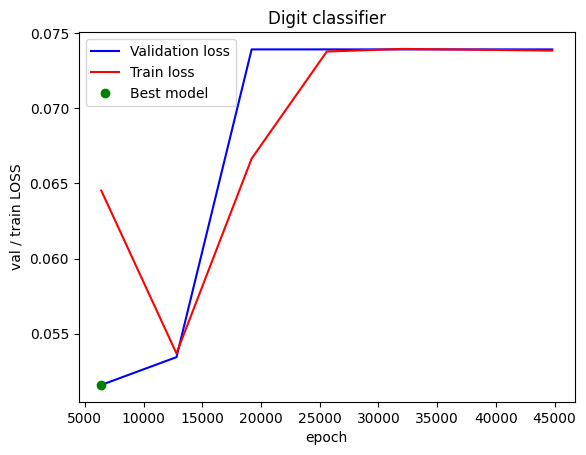

Testing lr:  0.1  and momentum:  0.9
Epoch 1 batch   200 
Train loss : 0.064
Validation loss mean : 0.058
New best model saved at 6400 samples
Epoch 1 of 5 took 5.924s
Epoch 2 batch    87 
Train loss : 0.060
Validation loss mean : 0.072
Epoch 2 batch   287 
Train loss : 0.073
Validation loss mean : 0.074
Epoch 2 of 5 took 9.319s
Epoch 3 batch   174 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 3 of 5 took 6.116s
Epoch 4 batch    61 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 4 batch   261 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 4 of 5 took 8.883s
Epoch 5 batch   148 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 5 of 5 took 6.584s
Finished Training


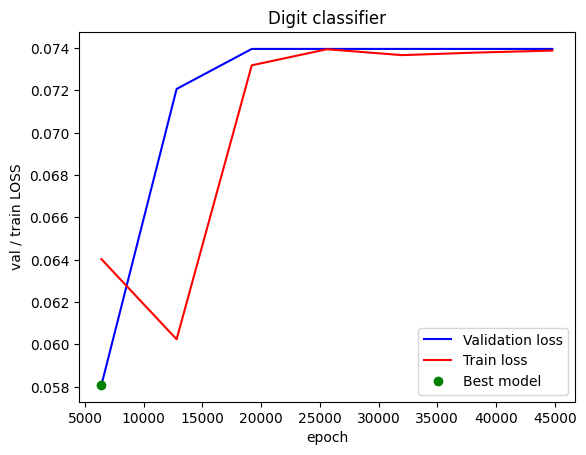

Testing lr:  0.1  and momentum:  0.95
Epoch 1 batch   200 
Train loss : 0.068
Validation loss mean : 0.074
New best model saved at 6400 samples
Epoch 1 of 5 took 5.899s
Epoch 2 batch    87 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 2 batch   287 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 2 of 5 took 9.286s
Epoch 3 batch   174 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 3 of 5 took 6.254s
Epoch 4 batch    61 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 4 batch   261 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 4 of 5 took 8.696s
Epoch 5 batch   148 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 5 of 5 took 6.498s
Finished Training


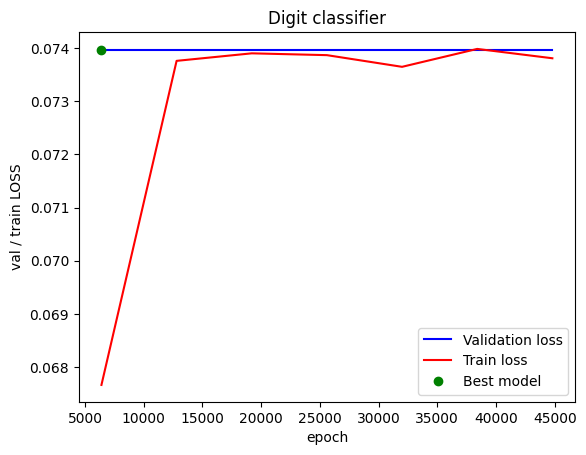

Testing lr:  0.1  and momentum:  0.99
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.074
New best model saved at 6400 samples
Epoch 1 of 5 took 5.889s
Epoch 2 batch    87 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 2 batch   287 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 2 of 5 took 9.280s
Epoch 3 batch   174 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 3 of 5 took 6.542s
Epoch 4 batch    61 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 4 batch   261 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 4 of 5 took 8.534s
Epoch 5 batch   148 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 5 of 5 took 6.521s
Finished Training


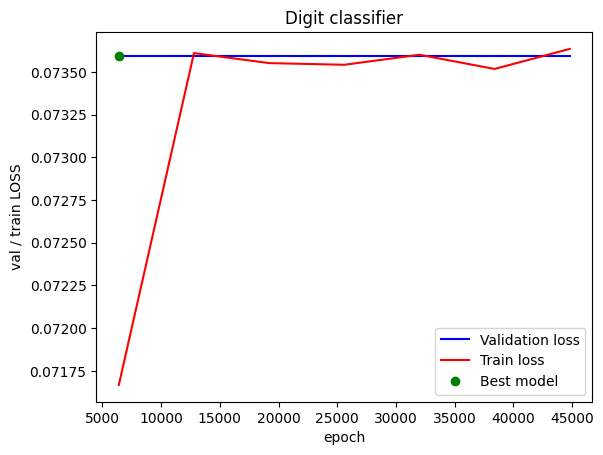

Testing lr:  0.05  and momentum:  0.8
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 5.769s
Epoch 2 batch    87 
Train loss : 0.068
Validation loss mean : 0.057
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.053
Validation loss mean : 0.051
New best model saved at 19200 samples
Epoch 2 of 5 took 9.181s
Epoch 3 batch   174 
Train loss : 0.049
Validation loss mean : 0.048
New best model saved at 25600 samples
Epoch 3 of 5 took 6.414s
Epoch 4 batch    61 
Train loss : 0.048
Validation loss mean : 0.047
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.047
Validation loss mean : 0.047
New best model saved at 38400 samples
Epoch 4 of 5 took 8.667s
Epoch 5 batch   148 
Train loss : 0.047
Validation loss mean : 0.047
Epoch 5 of 5 took 6.522s
Finished Training


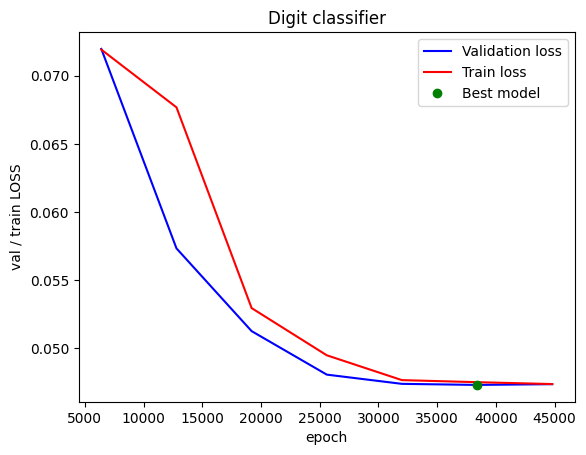

Testing lr:  0.05  and momentum:  0.85
Epoch 1 batch   200 
Train loss : 0.070
Validation loss mean : 0.060
New best model saved at 6400 samples
Epoch 1 of 5 took 5.938s
Epoch 2 batch    87 
Train loss : 0.054
Validation loss mean : 0.051
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.051
Validation loss mean : 0.051
New best model saved at 19200 samples
Epoch 2 of 5 took 9.211s
Epoch 3 batch   174 
Train loss : 0.050
Validation loss mean : 0.050
New best model saved at 25600 samples
Epoch 3 of 5 took 6.692s
Epoch 4 batch    61 
Train loss : 0.050
Validation loss mean : 0.050
Epoch 4 batch   261 
Train loss : 0.049
Validation loss mean : 0.048
New best model saved at 38400 samples
Epoch 4 of 5 took 8.664s
Epoch 5 batch   148 
Train loss : 0.047
Validation loss mean : 0.048
Epoch 5 of 5 took 6.535s
Finished Training


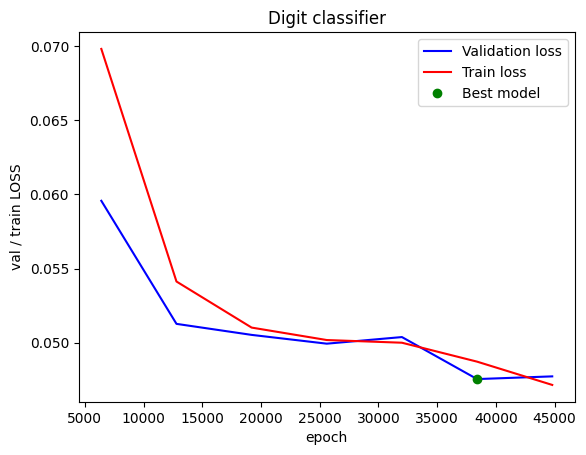

Testing lr:  0.05  and momentum:  0.9
Epoch 1 batch   200 
Train loss : 0.069
Validation loss mean : 0.058
New best model saved at 6400 samples
Epoch 1 of 5 took 5.947s
Epoch 2 batch    87 
Train loss : 0.052
Validation loss mean : 0.050
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.049
Validation loss mean : 0.048
New best model saved at 19200 samples
Epoch 2 of 5 took 9.168s
Epoch 3 batch   174 
Train loss : 0.049
Validation loss mean : 0.050
Epoch 3 of 5 took 6.481s
Epoch 4 batch    61 
Train loss : 0.053
Validation loss mean : 0.059
Epoch 4 batch   261 
Train loss : 0.063
Validation loss mean : 0.066
Epoch 4 of 5 took 8.724s
Epoch 5 batch   148 
Train loss : 0.069
Validation loss mean : 0.074
Epoch 5 of 5 took 6.273s
Finished Training


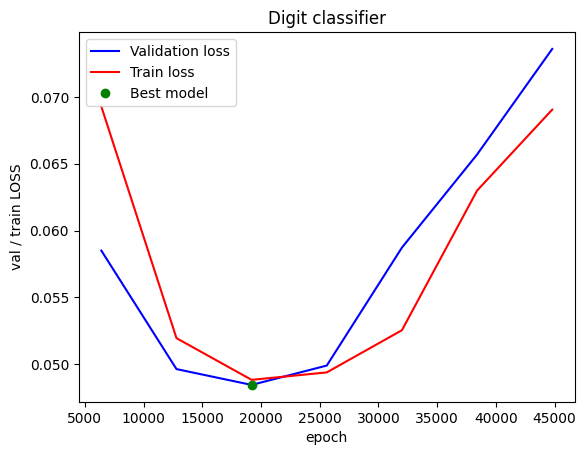

Testing lr:  0.05  and momentum:  0.95
Epoch 1 batch   200 
Train loss : 0.069
Validation loss mean : 0.068
New best model saved at 6400 samples
Epoch 1 of 5 took 6.061s
Epoch 2 batch    87 
Train loss : 0.069
Validation loss mean : 0.071
Epoch 2 batch   287 
Train loss : 0.069
Validation loss mean : 0.069
Epoch 2 of 5 took 8.876s
Epoch 3 batch   174 
Train loss : 0.067
Validation loss mean : 0.065
New best model saved at 25600 samples
Epoch 3 of 5 took 6.498s
Epoch 4 batch    61 
Train loss : 0.069
Validation loss mean : 0.073
Epoch 4 batch   261 
Train loss : 0.072
Validation loss mean : 0.071
Epoch 4 of 5 took 8.921s
Epoch 5 batch   148 
Train loss : 0.070
Validation loss mean : 0.071
Epoch 5 of 5 took 6.120s
Finished Training


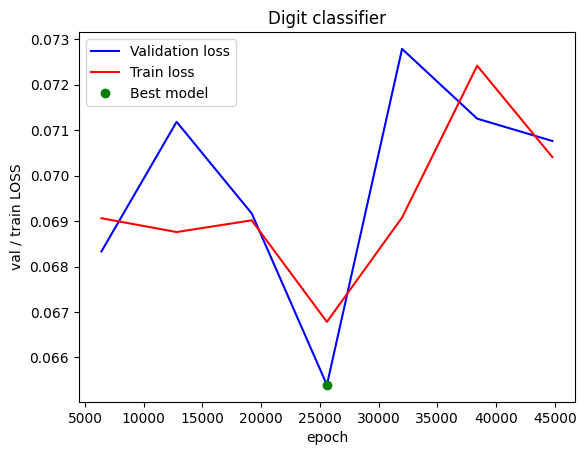

Testing lr:  0.05  and momentum:  0.99
Epoch 1 batch   200 
Train loss : 0.070
Validation loss mean : 0.073
New best model saved at 6400 samples
Epoch 1 of 5 took 6.490s
Epoch 2 batch    87 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 2 batch   287 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 2 of 5 took 8.581s
Epoch 3 batch   174 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 3 of 5 took 6.349s
Epoch 4 batch    61 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 4 batch   261 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 4 of 5 took 9.005s
Epoch 5 batch   148 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 5 of 5 took 5.843s
Finished Training


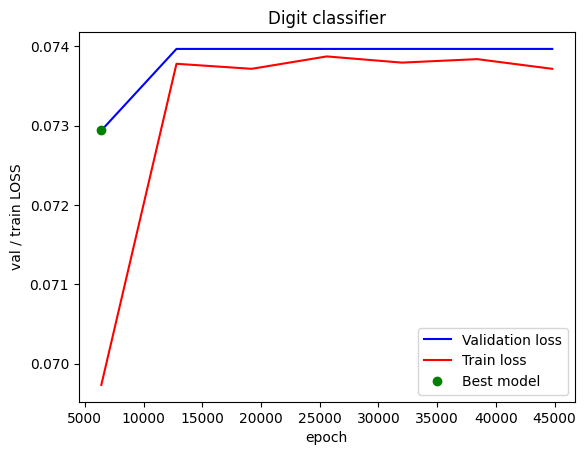

Testing lr:  0.01  and momentum:  0.8
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 6.339s
Epoch 2 batch    87 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 19200 samples
Epoch 2 of 5 took 8.589s
Epoch 3 batch   174 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 25600 samples
Epoch 3 of 5 took 6.448s
Epoch 4 batch    61 
Train loss : 0.072
Validation loss mean : 0.071
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.067
Validation loss mean : 0.062
New best model saved at 38400 samples
Epoch 4 of 5 took 9.195s
Epoch 5 batch   148 
Train loss : 0.059
Validation loss mean : 0.055
New best model saved at 44800 samples
Epoch 5 of 5 took 5.891s
Finished Training


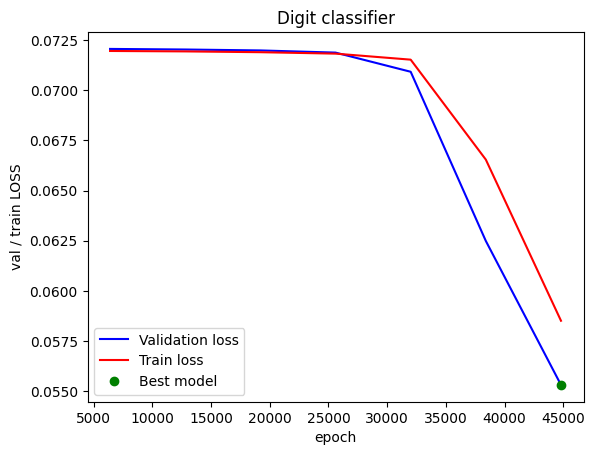

Testing lr:  0.01  and momentum:  0.85
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 6.443s
Epoch 2 batch    87 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 19200 samples
Epoch 2 of 5 took 8.717s
Epoch 3 batch   174 
Train loss : 0.072
Validation loss mean : 0.071
New best model saved at 25600 samples
Epoch 3 of 5 took 6.135s
Epoch 4 batch    61 
Train loss : 0.067
Validation loss mean : 0.062
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.057
Validation loss mean : 0.054
New best model saved at 38400 samples
Epoch 4 of 5 took 9.090s
Epoch 5 batch   148 
Train loss : 0.054
Validation loss mean : 0.054
New best model saved at 44800 samples
Epoch 5 of 5 took 5.760s
Finished Training


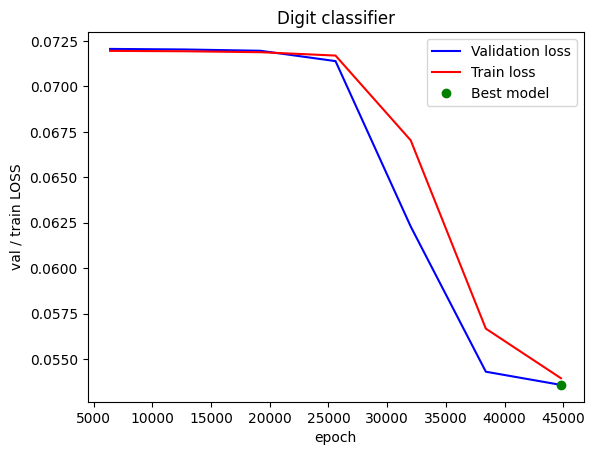

Testing lr:  0.01  and momentum:  0.9
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 6.366s
Epoch 2 batch    87 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.071
Validation loss mean : 0.069
New best model saved at 19200 samples
Epoch 2 of 5 took 9.181s
Epoch 3 batch   174 
Train loss : 0.064
Validation loss mean : 0.057
New best model saved at 25600 samples
Epoch 3 of 5 took 5.826s
Epoch 4 batch    61 
Train loss : 0.053
Validation loss mean : 0.050
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.049
Validation loss mean : 0.049
New best model saved at 38400 samples
Epoch 4 of 5 took 9.048s
Epoch 5 batch   148 
Train loss : 0.048
Validation loss mean : 0.048
New best model saved at 44800 samples
Epoch 5 of 5 took 5.818s
Finished Training


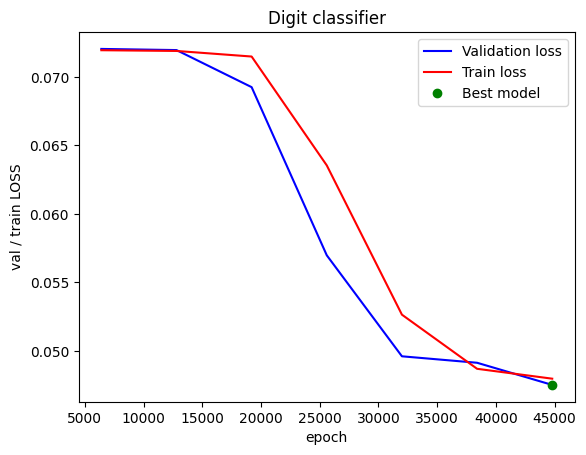

Testing lr:  0.01  and momentum:  0.95
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 6.418s
Epoch 2 batch    87 
Train loss : 0.068
Validation loss mean : 0.057
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.055
Validation loss mean : 0.052
New best model saved at 19200 samples
Epoch 2 of 5 took 9.231s
Epoch 3 batch   174 
Train loss : 0.052
Validation loss mean : 0.051
New best model saved at 25600 samples
Epoch 3 of 5 took 5.822s
Epoch 4 batch    61 
Train loss : 0.051
Validation loss mean : 0.050
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.051
Validation loss mean : 0.051
Epoch 4 of 5 took 9.041s
Epoch 5 batch   148 
Train loss : 0.050
Validation loss mean : 0.050
New best model saved at 44800 samples
Epoch 5 of 5 took 5.899s
Finished Training


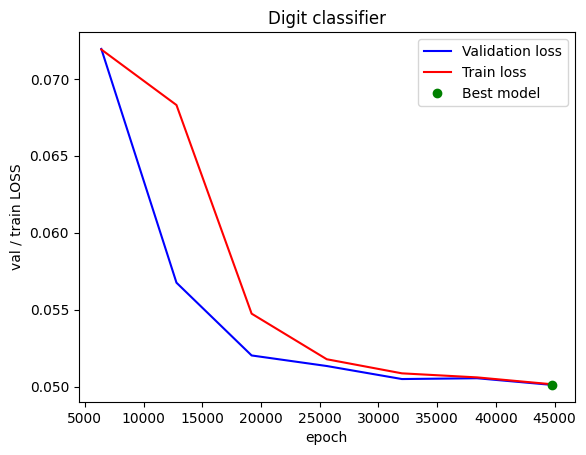

Testing lr:  0.01  and momentum:  0.99
Epoch 1 batch   200 
Train loss : 0.071
Validation loss mean : 0.063
New best model saved at 6400 samples
Epoch 1 of 5 took 6.329s
Epoch 2 batch    87 
Train loss : 0.059
Validation loss mean : 0.063
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.069
Validation loss mean : 0.074
Epoch 2 of 5 took 9.089s
Epoch 3 batch   174 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 3 of 5 took 5.818s
Epoch 4 batch    61 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 4 batch   261 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 4 of 5 took 9.130s
Epoch 5 batch   148 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 5 of 5 took 6.404s
Finished Training


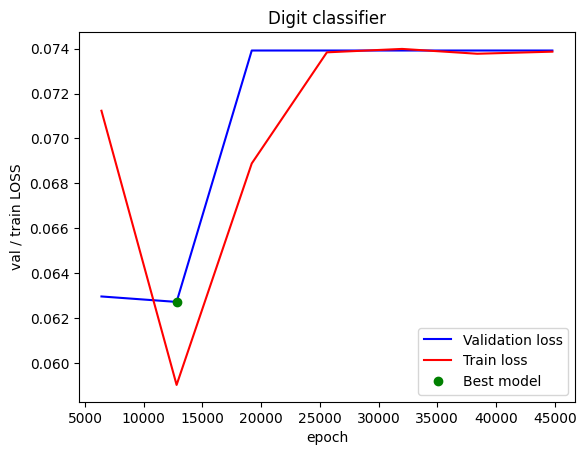

Testing lr:  0.005  and momentum:  0.8
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 5.863s
Epoch 2 batch    87 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 19200 samples
Epoch 2 of 5 took 9.019s
Epoch 3 batch   174 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 25600 samples
Epoch 3 of 5 took 5.811s
Epoch 4 batch    61 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 38400 samples
Epoch 4 of 5 took 9.215s
Epoch 5 batch   148 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 44800 samples
Epoch 5 of 5 took 6.392s
Finished Training


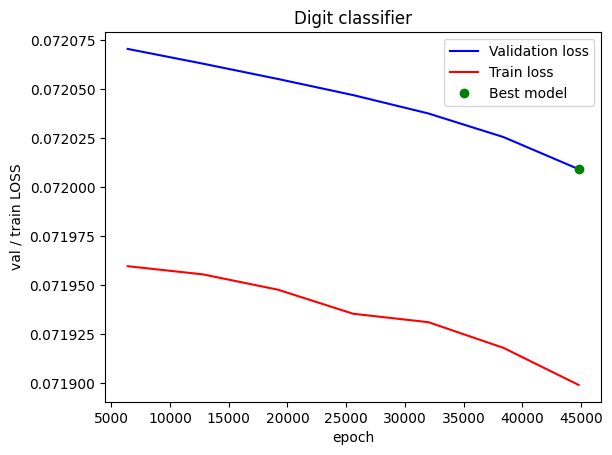

Testing lr:  0.005  and momentum:  0.85
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 5.781s
Epoch 2 batch    87 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 19200 samples
Epoch 2 of 5 took 8.999s
Epoch 3 batch   174 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 25600 samples
Epoch 3 of 5 took 5.938s
Epoch 4 batch    61 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 38400 samples
Epoch 4 of 5 took 9.021s
Epoch 5 batch   148 
Train loss : 0.070
Validation loss mean : 0.068
New best model saved at 44800 samples
Epoch 5 of 5 took 6.355s
Finished Training


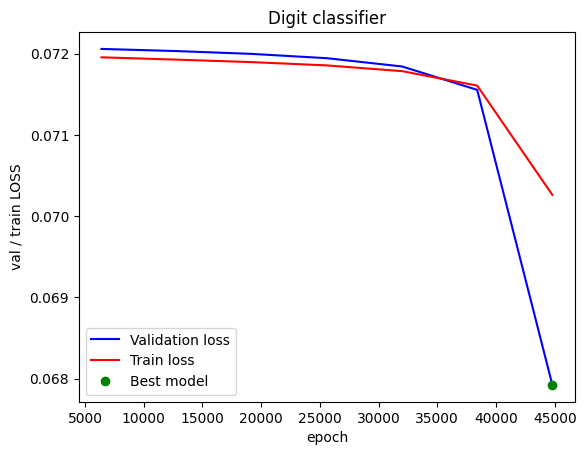

Testing lr:  0.005  and momentum:  0.9
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 5.793s
Epoch 2 batch    87 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 19200 samples
Epoch 2 of 5 took 9.045s
Epoch 3 batch   174 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 25600 samples
Epoch 3 of 5 took 6.101s
Epoch 4 batch    61 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.071
Validation loss mean : 0.069
New best model saved at 38400 samples
Epoch 4 of 5 took 8.963s
Epoch 5 batch   148 
Train loss : 0.062
Validation loss mean : 0.056
New best model saved at 44800 samples
Epoch 5 of 5 took 6.366s
Finished Training


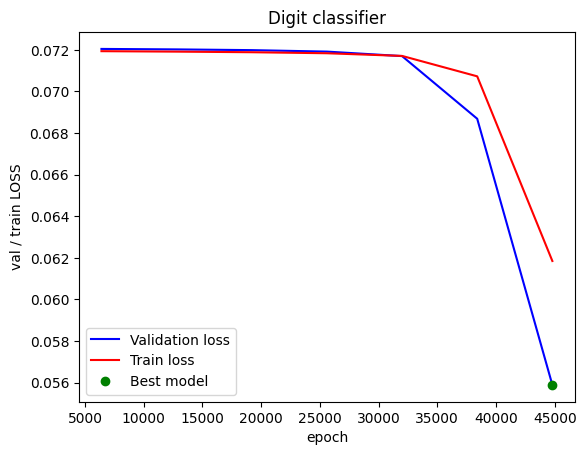

Testing lr:  0.005  and momentum:  0.95
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 5.808s
Epoch 2 batch    87 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.071
Validation loss mean : 0.067
New best model saved at 19200 samples
Epoch 2 of 5 took 8.996s
Epoch 3 batch   174 
Train loss : 0.055
Validation loss mean : 0.052
New best model saved at 25600 samples
Epoch 3 of 5 took 6.355s
Epoch 4 batch    61 
Train loss : 0.051
Validation loss mean : 0.051
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.051
Validation loss mean : 0.050
New best model saved at 38400 samples
Epoch 4 of 5 took 8.523s
Epoch 5 batch   148 
Train loss : 0.050
Validation loss mean : 0.050
New best model saved at 44800 samples
Epoch 5 of 5 took 6.449s
Finished Training


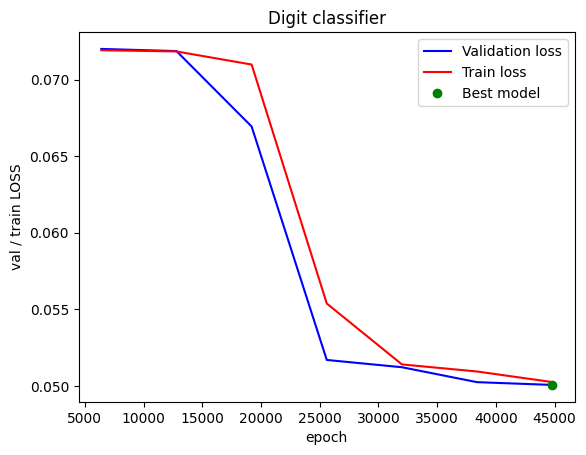

Testing lr:  0.005  and momentum:  0.99
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 5.901s
Epoch 2 batch    87 
Train loss : 0.064
Validation loss mean : 0.058
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.058
Validation loss mean : 0.058
New best model saved at 19200 samples
Epoch 2 of 5 took 9.140s
Epoch 3 batch   174 
Train loss : 0.060
Validation loss mean : 0.061
Epoch 3 of 5 took 6.347s
Epoch 4 batch    61 
Train loss : 0.065
Validation loss mean : 0.065
Epoch 4 batch   261 
Train loss : 0.068
Validation loss mean : 0.074
Epoch 4 of 5 took 8.462s
Epoch 5 batch   148 
Train loss : 0.074
Validation loss mean : 0.074
Epoch 5 of 5 took 6.316s
Finished Training


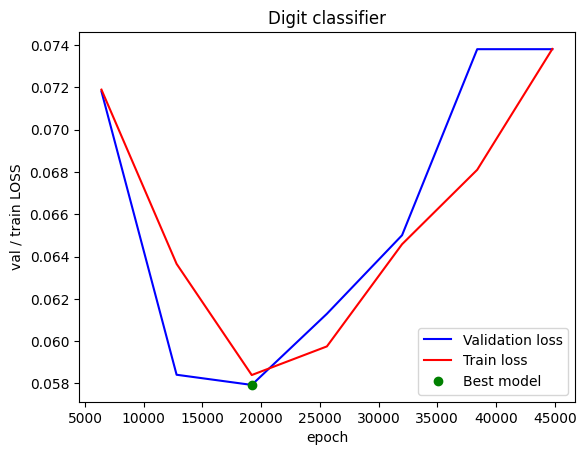

Testing lr:  0.001  and momentum:  0.8
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 5.861s
Epoch 2 batch    87 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 19200 samples
Epoch 2 of 5 took 8.982s
Epoch 3 batch   174 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 25600 samples
Epoch 3 of 5 took 6.400s
Epoch 4 batch    61 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 38400 samples
Epoch 4 of 5 took 8.706s
Epoch 5 batch   148 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 44800 samples
Epoch 5 of 5 took 6.377s
Finished Training


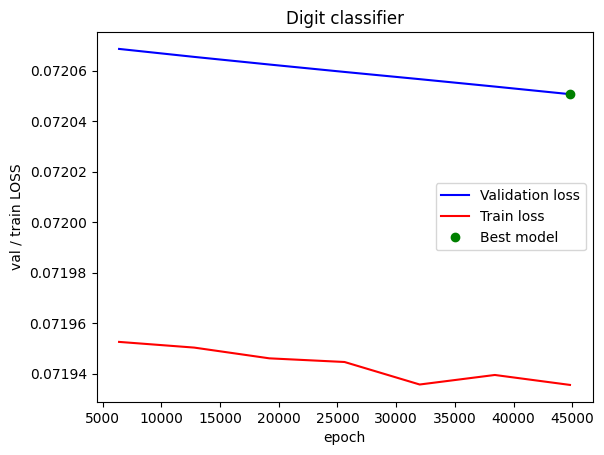

Testing lr:  0.001  and momentum:  0.85
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 6.147s
Epoch 2 batch    87 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 19200 samples
Epoch 2 of 5 took 8.829s
Epoch 3 batch   174 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 25600 samples
Epoch 3 of 5 took 6.400s
Epoch 4 batch    61 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 38400 samples
Epoch 4 of 5 took 8.806s
Epoch 5 batch   148 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 44800 samples
Epoch 5 of 5 took 6.009s
Finished Training


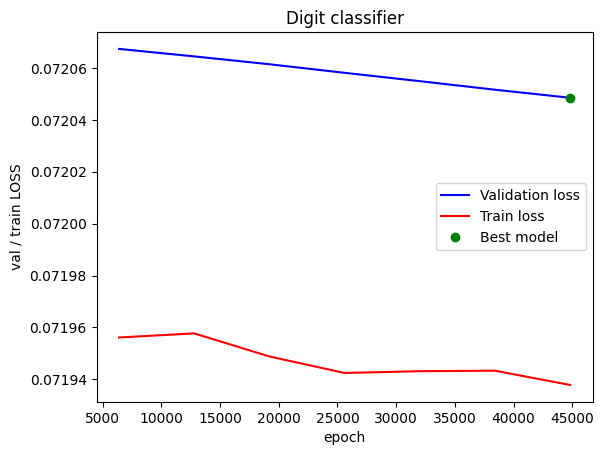

Testing lr:  0.001  and momentum:  0.9
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 6.369s
Epoch 2 batch    87 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 19200 samples
Epoch 2 of 5 took 8.546s
Epoch 3 batch   174 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 25600 samples
Epoch 3 of 5 took 6.461s
Epoch 4 batch    61 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 38400 samples
Epoch 4 of 5 took 8.992s
Epoch 5 batch   148 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 44800 samples
Epoch 5 of 5 took 5.800s
Finished Training


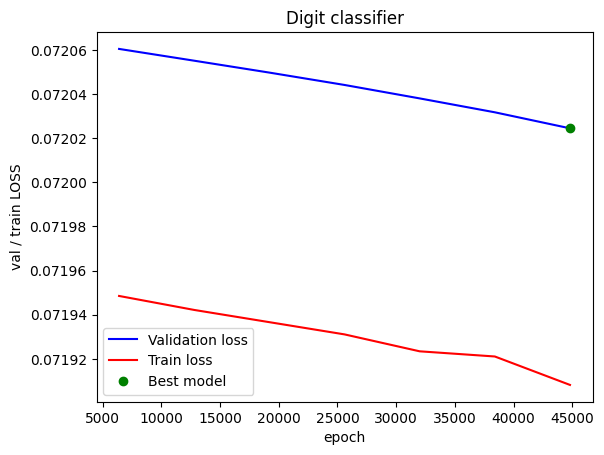

Testing lr:  0.001  and momentum:  0.95
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 6.497s
Epoch 2 batch    87 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 19200 samples
Epoch 2 of 5 took 8.437s
Epoch 3 batch   174 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 25600 samples
Epoch 3 of 5 took 6.247s
Epoch 4 batch    61 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 38400 samples
Epoch 4 of 5 took 8.997s
Epoch 5 batch   148 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 44800 samples
Epoch 5 of 5 took 5.734s
Finished Training


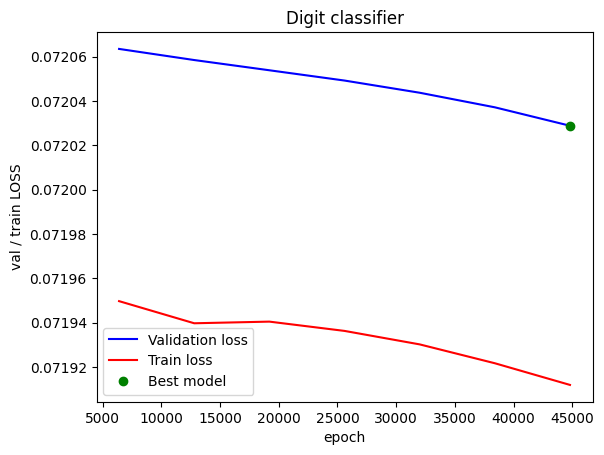

Testing lr:  0.001  and momentum:  0.99
Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 1 of 5 took 6.465s
Epoch 2 batch    87 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 12800 samples
Epoch 2 batch   287 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 19200 samples
Epoch 2 of 5 took 8.408s
Epoch 3 batch   174 
Train loss : 0.072
Validation loss mean : 0.071
New best model saved at 25600 samples
Epoch 3 of 5 took 6.243s
Epoch 4 batch    61 
Train loss : 0.066
Validation loss mean : 0.062
New best model saved at 32000 samples
Epoch 4 batch   261 
Train loss : 0.058
Validation loss mean : 0.055
New best model saved at 38400 samples
Epoch 4 of 5 took 8.924s
Epoch 5 batch   148 
Train loss : 0.054
Validation loss mean : 0.055
New best model saved at 44800 samples
Epoch 5 of 5 took 5.832s
Finished Training


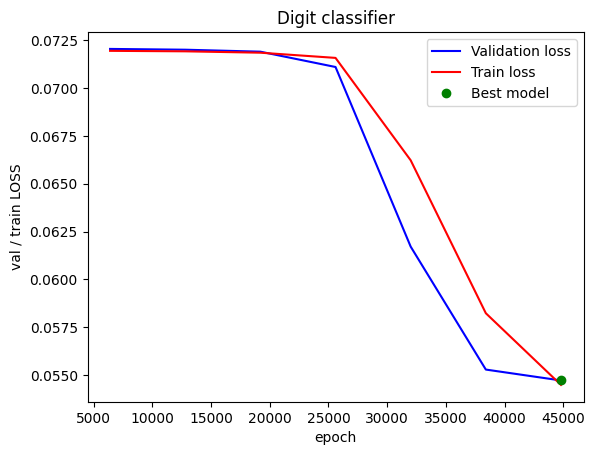

Best learning rate:  0.05
Best momentum:  0.8


In [ ]:
# Making the meta-parameter vary to find the best one
# We make both the lr and the momentum vary to find the best combination for our Network

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
momentums = [0.8, 0.85, 0.9, 0.95, 0.99]

best_loss = float('inf')
best_lr = None
best_momentum = None
best_train_errs = None
best_val_errs = None

for lr in learning_rates:
    for momentum in momentums:
        print("Testing lr: ", lr, " and momentum: ", momentum)
        test_net = NetCNN()
        test_net.to(device)
        optimizer = optim.SGD(test_net.parameters(), lr=lr, momentum=momentum)
        criterion = nn.CrossEntropyLoss()
        model, train_errs, val_errs = train_network(test_net, trainloader, validationloader, validationset, criterion, optimizer, num_epochs = 5, print_every = 200)
        val_loss = val_errs[-1]
        if val_loss < best_loss:
            best_loss = val_loss
            best_lr = lr
            best_momentum = momentum
            best_train_errs = train_errs
            best_val_errs = val_errs

print('Best learning rate: ', best_lr)
print('Best momentum: ', best_momentum)




Epoch 1 batch   200 
Train loss : 0.069
Validation loss mean : 0.067
New best model saved at 6400 samples
Epoch 1 batch   400 
Train loss : 0.066
Validation loss mean : 0.063
New best model saved at 12800 samples
Epoch 1 batch   600 
Train loss : 0.060
Validation loss mean : 0.057
New best model saved at 19200 samples
Epoch 1 batch   800 
Train loss : 0.056
Validation loss mean : 0.056
New best model saved at 25600 samples
Epoch 1 of 5 took 22.709s
Epoch 2 batch    62 
Train loss : 0.055
Validation loss mean : 0.054
New best model saved at 32000 samples
Epoch 2 batch   262 
Train loss : 0.054
Validation loss mean : 0.054
New best model saved at 38400 samples
Epoch 2 batch   462 
Train loss : 0.053
Validation loss mean : 0.053
New best model saved at 44800 samples
Epoch 2 batch   662 
Train loss : 0.053
Validation loss mean : 0.053
New best model saved at 51200 samples
Epoch 2 batch   862 
Train loss : 0.053
Validation loss mean : 0.052
New best model saved at 57600 samples
Epoch 2 of 5

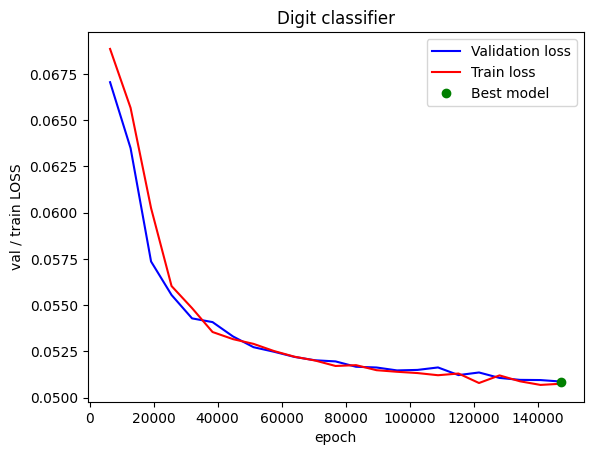

Accuracy:  84.18 %
Error rate:  15.819999999999993 %
Confusion Matrix: 
  [[ 903    0   55   10    0    0    1    9    2    0]
 [   0 1104    6    0    0    0   13    0   12    0]
 [  14    0  950   31    2    0   18    3    7    7]
 [   9    0   39  930    0    0    0   12   18    2]
 [   0   18    2    0  931    0   12    0    2   17]
 [   7    1   66  251    1    0   17   10  506   33]
 [   4    8   38    1    4    0  898    0    5    0]
 [   8    1    8   81    0    0    0  900    8   22]
 [   1   12   11   40    4    0   12    0  886    8]
 [   1    4    2   25   22    0    0   18   21  916]]
Complexity :  4651


(84.18, 4651)

In [ ]:
# reduce the complexity of the model
# we create a duplicate of the base model with a way lower complexity by reducing the number of neuron from each layer

class NetCNN2(nn.Module):
    def __init__(self):
        super(NetCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 5)
        self.fc2 = nn.Linear(5, 10)
        self.fc3 = nn.Linear(10, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

test2_net = NetCNN2()
test2_net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(test2_net.parameters(), lr=0.001) # On essaye Adam plutôt que SGD pour voir la différence d'accuracy
complex_model, complex_train_errs, complex_val_errs = train_network(test2_net, trainloader, validationloader, validationset, criterion, optimizer, num_epochs = 5, print_every = 200)
evaluate(complex_model, testloader, device)



[Preuve de 15.81% d'error rate avec 4615 de complexité](https://drive.google.com/file/d/1H0RFfaqbHZp51du68IRWU5do06gZdQXi/view?usp=sharing)

http://127.26.83.28:3827/

Epoch 1 batch   200 
Train loss : 0.071
Validation loss mean : 0.070
New best model saved at 6400 samples
Epoch 1 batch   400 
Train loss : 0.067
Validation loss mean : 0.065
New best model saved at 12800 samples
Epoch 1 batch   600 
Train loss : 0.064
Validation loss mean : 0.063
New best model saved at 19200 samples
Epoch 1 batch   800 
Train loss : 0.063
Validation loss mean : 0.062
New best model saved at 25600 samples
Epoch 1 of 5 took 33.826s
Epoch 2 batch    62 
Train loss : 0.062
Validation loss mean : 0.062
New best model saved at 32000 samples
Epoch 2 batch   262 
Train loss : 0.062
Validation loss mean : 0.062
New best model saved at 38400 samples
Epoch 2 batch   462 
Train loss : 0.062
Validation loss mean : 0.062
Epoch 2 batch   662 
Train loss : 0.062
Validation loss mean : 0.062
New best model saved at 51200 samples
Epoch 2 batch   862 
Train loss : 0.062
Validation loss mean : 0.061
New best model saved at 57600 samples
Epoch 2 of 5 took 25.206s
Epoch 3 batch   124 
Tra

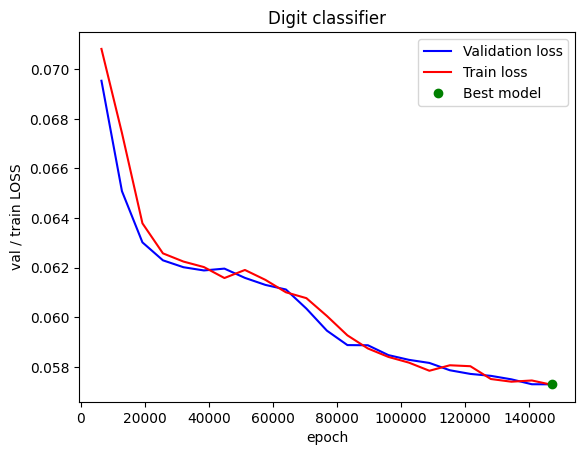

Accuracy:  63.1 %
Error rate:  36.9 %
Confusion Matrix: 
  [[ 918   13    0    0    2    1   26    1   19    0]
 [  28 1073    0    0    0    1    2    0   31    0]
 [ 497  221    0    0   20   10  146   12  108   18]
 [ 302   82    0    0    6   16  144   71  368   21]
 [   0    0    0    0  905    6   21    0    4   46]
 [ 146   28    0    0   45   52  147   17  384   73]
 [  68    0    0    0    6    1  876    0    7    0]
 [   1   28    0    0    0    1    0  929   42   27]
 [  97   80    0    0   11   19   31   50  667   19]
 [   6    1    0    0   39    1    2   15   55  890]]
Complexity :  1019


(63.1, 1019)

In [ ]:
# we try with an even less complex model to see if we can be in the Pareto front for a not bad simple model

class NetCNN3(nn.Module):
    def __init__(self):
        super(NetCNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)  # reduce output channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 6, 5)  # reduce output channels
        self.fc1 = nn.Linear(6 * 5 * 5, 3)  # reduce number of neurons
        self.fc2 = nn.Linear(3, 5)  # reduce number of neurons
        self.fc3 = nn.Linear(5, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

test3_net = NetCNN3()
test3_net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.Adam(test3_net.parameters(), lr=0.001)
complex_model2, complex_train_errs, complex_val_errs = train_network(test3_net, trainloader, validationloader, validationset, criterion, optimizer, num_epochs = 5, print_every = 200)
evaluate(complex_model2, testloader, device)

[Preuve de 36.9% d'erorr rate avec 1019 de complexité](https://drive.google.com/file/d/1uejU81VX0EDdY70vhg_dt6o-KWPPMOIR/view?usp=sharing)

## Q2: Draw the Pareto front collectively
Agregate all the results from the group to draw a full Pareto front. Do not hesitate to change the architecture to explore the full tradeoff **complexity/error rate**.